# Projet Simulation Numérique ENSEEIHT 2022-2023
### Groupe: 2SN-B1
### Nom: Testu
### Prénom: François
### Commentaire: 

# Informations pratiques

**Modalités pédagogiques** 

Le projet Simulation Numérique vise à vous faire découvrir un algorithme particulier en lien avec d'autres modules d'enseignement de cette année et d'illustrer certaines notions et propriétés à partir de programmes simples que vous devez écrire ou bien compléter. Le langage de programmation proposé est Python. Une connaissance basique de Python et de Numpy est suffisante. 

Cette année, il vous est demandé en premier lieu un travail de compréhension des algorithmes principaux sur la base du C/TD du 10/3/23 et des liens en fin de Notebook. Ensuite est demandé un travail d'implantation informatique simple (partie A) et quelques applications sur des images vous sont proposées (partie B). Ce travail est notamment guidé, des questions de compréhension sur les algorithmes sont posées en Partie C. La partie D vous permet d'implanter un algorithme populaire à titre de comparaison. Le volume de travail demandé est raisonnable.

**Enseignement**

Voici les informations concernant les séances (date, heure):

10/3/23 14.00-16.00 C/TD Groupes B1 et B2 (B306)

14/3/23 14.00-18.00 TP Groupe B1 (C306)

17/3/23 08.00-12.00 TP Groupe B2 (C203)

24/3/23 14.00-16.00 TD Séance de réponse à vos questions (B306)

**Evaluation**

L'évaluation se basera uniquement sur le Notebook que vous devrez rendre. 

**Date limite de rendu**:  19 avril 2023 à midi. 

**Contact**: xavier.vasseur@irit.fr

Merci d'indiquer [PSN] en sujet de votre email pour m'aider à identifier vos requêtes.

**Préambule** L'objectif de ce projet est d'analyser quelques algorithmes de factorisation structurée (déterministe ou aléatoire) de matrices de grande taille. Nous nous intéressons à des algorithmes de factorisation dits "Interpolative Decomposition (ID)" ou "CUR-ID", où l'on cherche à approcher au mieux une matrice en un produit de matrices de rang faible. Les algorithmes seront comparés si possible sous différents angles: temps de calcul, complexité opératoire, précision numérique notamment. Nous envisagerons également l'utilisation d'algorithme dit de factorisation non-négative en fin de projet.

**NB:** Il vous est demandé d'insérer vos commentaires et codes **uniquement** dans ce fichier Notebook. Vous avez toute liberté pour créer des cellules soit de texte soit de code. Vous devez disposer comme données de ce fichier et de quelques images au format .jpg. Le rendu sera uniquement ce fichier Notebook dans lequel vous devez insérer l'ensemble de vos résultats. 

Ce projet est en lien notamment avec les cours suivants:

   * Calcul scientifique
   * Algèbre linéaire pour le data mining
   * Optimisation II

In [2]:
#
# Chargement des bibliotheques pour la visualisation, l'algebre lineaire et l'analyse du temps de calcul 
#
import matplotlib.pyplot as plt
import numpy as np
from   scipy import fftpack
from   scipy.linalg import qr, norm, solve_triangular, svd
from   PIL import Image
import time

### Introduction.

L'approximation de rang faible que nous utiliserons dans ce projet se base sur une connaissance du rang exact ou du rang approché de la matrice étudiée. A titre informatif, la méthode suivante vous permet d'obtenir une majoration du rang d'une matrice rectangulaire $A$ telle que $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$, $\epsilon$ désignant une tolérance choisie par l'utilisateur. Cette méthode sera donc utile par la suite dans vos expérimentations numériques, aucune modification n'est a priori requise. 


In [3]:
def adaptive_rank_determination(A,epsilon,blocking=16,iteration_max=10):
    """
    Adaptive rank determination based on randomization
    We look for an orthogonal matrix Q such that 
    $\|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    where $\|.\|_F$ denotes the Frobenius norm.
    
    Reference: Adapted from Section 12 of P.G. Martinsson, "Randomized methods for matrix computations", 2019, 
    ArXiv 1607.01649 [https://arxiv.org/pdf/1607.01649.pdfs]. The original algorithm corresponds to 
    Figure 12. 
    
    Input: 
    A:        matrix to be analysed [array type] (of shape (m,n))
    epsilon:  relative threshold related to the accuracy of the projection (in the Frobenius norm) (0<= epsilon <= 1)
    blocking: blocking parameter to be used in the implementation (for efficiency reasons) [int]
    
    Output:
    Q: matrix with orthonormal columns such that $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    erank: estimated rank (upper bound of epsilon-rank(A)), erank is here a multiple of min(blocking,n). 
    ratio: current ratio of $\|A - Q Q^T A \|_F4$ divided by $\|A \|_F$
    iteration: nombre d'itérations réalisé au sein de l'algorithme
    """ 
    
    m, n          = A.shape[:]
    # The blocking parameter should be less than the number of columns
    b             = min(blocking,n)
    iteration     = 0
    # Update the maximal number of iterations according to b
    iteration_max = max(np.ceil(n/b),iteration_max) 
    norm_A_Fro = norm(A,'fro')
    
    while norm(A,'fro') > epsilon*norm_A_Fro and iteration < iteration_max:
        # Create R the random block based on Gaussian variables
        R      = np.random.randn(n,b)
        # Matrix-matrix product Y = AR 
        Y      = A@R
        # QR decomposition of Y
        QY, RY = qr(Y,mode='economic')
        # Compute the projection 
        BY     = QY.T@A
        # Concatenate the information related to Q and B
        if iteration == 0:
            Q  = QY
            B  = BY###
        else:
            Q  = np.concatenate((Q, QY),axis=1)
            B  = np.concatenate((B, BY),axis=0)
        # Update the iteration count
        iteration += 1
        # Update of A
        A = A - QY@BY
        # Upper bound of epsilon-rank
        erank = Q.shape[1]
        
    return Q, Q.shape[1], norm(A,'fro')/norm_A_Fro, iteration

## Partie A.1

Proposer une implantation des différents algorithmes de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie C). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [4]:
def column_ID(A,k):
    """
    Compute a column interpolative decomposition such that 
    A \approx A[:,J] Z
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    ###
    Output:
    J  is the set of column indices [array, any type] (of shape k)
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    Z    = np.zeros(shape=(k,n))
    
    #
    # TO DO
    #
    # Perform the economic decomposition of A with column pivoting 
    _, S, J = qr(A, mode = 'economic', pivoting = True)
    
    # Deduce the T=R11^{-1}R12 block 
    T = solve_triangular(S[0:k,0:k], S[0:k,k:n])
    
    # Deduce J and Z 
    Ik = np.eye(k)
    Z[:,J] = np.concatenate((Ik, T), axis = 1)
    J = J[0:k]
    #
    # END TO DO
    #
    print(Z)
    
    return J,Z


def row_ID(A,k):
    """
    Compute a row interpolative decomposition such that 
    A \approx X A[I,:] 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array, any type] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k))
    
    #
    # TO DO
    #
    
    # Perform the economic decomposition of A^T with column pivoting 
    _, S, J = qr(np.transpose(A), mode = 'economic', pivoting = True)
    
        
    # Deduce the corresponding T block 
    T = solve_triangular(S[0:k,0:k], S[0:k,k:m])
    
    
    # Deduce I and X 
    Ik = np.eye(k)
    X[J,:] = np.transpose(np.concatenate((Ik, T), axis = 1))
    I = J[0:k]

    #
    # END TO DO
    #
    
    return I,X

def double_sided_ID(A,k):
    """
    Compute a double sided interpolative decomposition such that 
    A \approx X A(I,J) Z 
    
    Input: 
    A matrix to be analysed [array type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array] (of shape k)
    J  is the set of column indices [array] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    #
    # TO DO
    #
    
    # Apply the column ID to A
    J, Z = column_ID(A, k)

    
   
    # Apply the row ID to A[:,J]
    I, X = row_ID(A[:,J], k)
    
    #
    # END TO DO
    #
    
    return I,J,X,Z

def extract_subblock(A,I,J):
    """
    Given a set of row and column indices, extract the submatrix 
    B = A[I,J]
    with I the set of row indices and J the set of column indices.
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    I  is the set of row indices  (of shape k)
    J  is the set of column indices  (of shape k)
    
    Output:
    Matrix A[I,J] [array] (of shape (k,k))
    """
    B = np.zeros(shape=(len(I),len(J)))
    row_index = 0
    
    for i in I:
        col_index = 0
        for j in J:
            B[row_index,col_index] = A[i,j]
            col_index = col_index + 1
            
        row_index = row_index + 1
    
    return B

def cur(A,k):
    """
    Deterministic version of the CUR algorithm based on the 
    double sided ID decomposition. 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    #
    # TO DO
    #
    
    # Apply the double sided interpolation algorithm 
    I,J,_,Z = double_sided_ID(A,k)
    
    
    # Deduce the C and R matrices of the CUR formulation 
    C = A[:,J]
    R = A[I,:]
    
    # Solve U R = Z in a least-squares sense
    U = Z@np.linalg.pinv(R)
    
    #
    # END TO DO
    #
    return I,J,C,U,R

## Partie A.2 

Proposer une implantation des différents algorithmes aléatoires de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie D). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [5]:
def randomized_row_ID(A,k,p=10,q=2):
    """
    Randomized version of the row ID to decompose matrix A into
    A \approx X A(I,:) 
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)
    
    Output:
    I  is the set of row indices  (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.4 and Figure 8 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    
    """
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k)) 
    
    # Use the randomized variant to construct Y an approximation of A
    G    = np.random.randn(n,k+p)
    Y    = A@G
   
    #
    # TO DO
    #
   
    
    # Apply the row ID algorithm to Y
    for j in range(q):
        Y_aux = A@Y
        Y = A@Y_aux

    I, X = row_ID(Y,k)
    
    
    #
    # END TO DO
    #
    
    return I,X

   
def randomized_cur(A,k,p=10,q=2):
    """
    Randomized version of the CUR algorithm     
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 and Figure 10 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """    
    m, n = A.shape[:]
    
    # Randomized version starts here
    # Use the randomized variant to construct Y an approximation of A
     
    G    = np.random.randn(k+p,m)
    Y    = G@A
    
    #
    # TO DO
    #
    
        
    # Apply the column ID algorithm to Y 
    for j in range(q):
        Z = Y@np.transpose(A)
        Y = Z@A

    J, Z = column_ID(Y,k)
    
    
    # Apply the row ID algorithm to A[:,J]
    I, _ = row_ID(A[:,J],k)
    
        
    # Deduce the CUR matrices (C, R and then U)
    U = Z@np.linalg.pinv(A[I, :])
    C = A[:, J]
    R = A[I, :]
    
    #
    # END TO DO
    #
    return I,J,C,U,R

## Partie B

Nous cherchons à mettre en oeuvre les algorithmes précédents sur une application liée à la reconstruction d'images.
La cellule suivante vous montre comment charger une image et en déduire la matrice associée. Appliquer alors les algorithmes de 
factorisation vus en Partie A et visualiser les images obtenues en fonction du rang estimé.  

### Sydney

(396, 563)


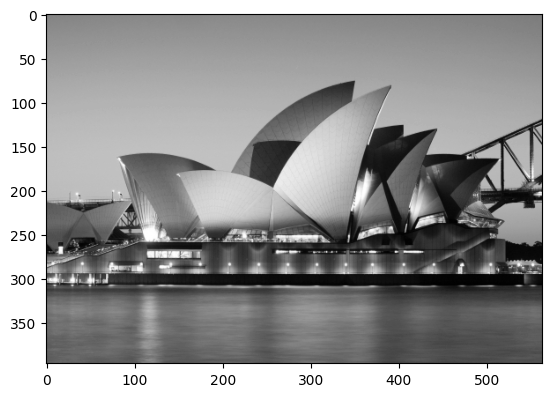

In [6]:
#
# Lecture de l'image 
#
#
imgc = Image.open("Sydney_Opera_House.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M        = (1./255)*np.array(img_gray)
M_Sydney = M[:]
#
# Affichage de la taille de l'image et de l'image en gris si besoin
#
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.04320883750915527
Estimated upper bound of the epsilon-rank:  96  for relative threshold:  0.05
Frobenius norm ratio:  0.04163077824521077  reached in  6 iterations
[[ 0.         -0.05907996 -0.09709201 ...  0.02003822  0.
   0.        ]
 [ 0.         -0.05130874 -0.0868541  ...  0.00887972  0.
   0.        ]
 [ 0.          0.00798008  0.01565235 ...  0.01828878  0.
   0.        ]
 ...
 [ 0.         -0.00937458 -0.02413695 ...  0.05035697  0.
   0.        ]
 [ 0.          0.04123182  0.04167294 ...  0.06487189  0.
   0.        ]
 [ 0.          0.04413787  0.05185446 ... -0.03503028  0.
   0.        ]]
Time spent in the CUR algorithm 0.07200145721435547
[[-0.0554371  -0.04605657 -0.15529235 ...  0.          0.18349347
   0.        ]
 [ 0.58941994  0.37849553  0.23384919 ...  0.         -0.16149252
   0.        ]
 [-0.96881213 -0.66936806 -0.39158081 ...  0.          0.15471189
   0.        ]
 ...
 [-0.29790622 -0.1986986

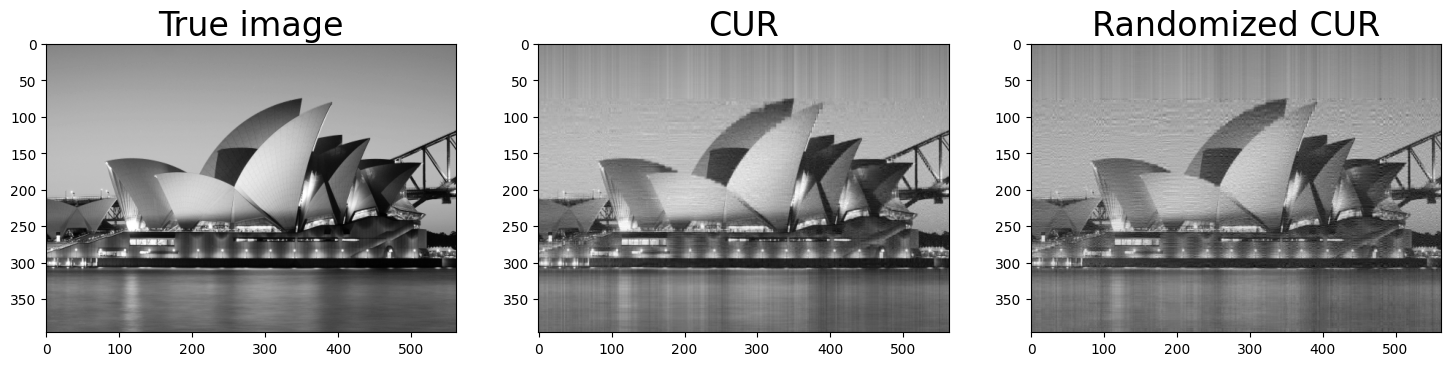

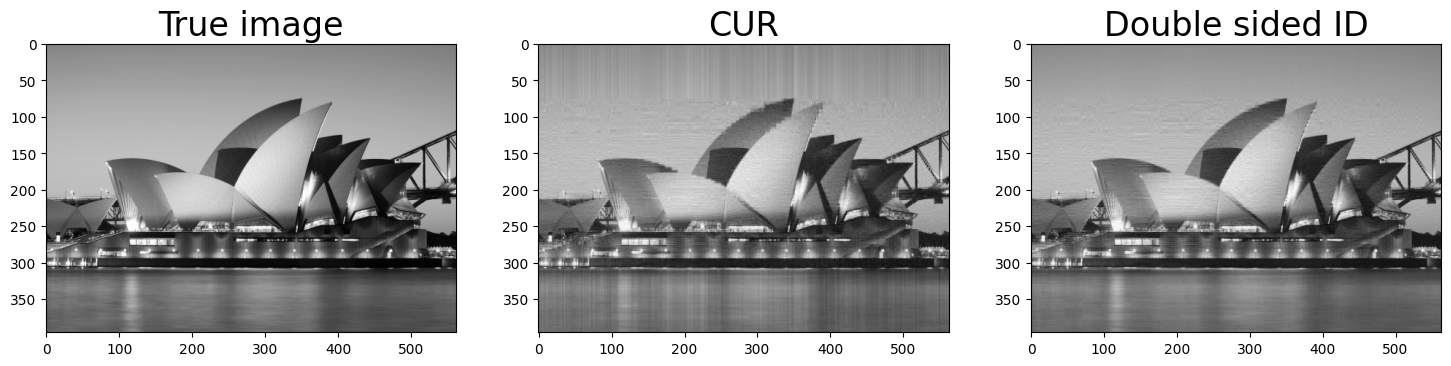

In [7]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
epsilon  = 0.05
blocking = 16
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Sydney = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I, J, C, U, R  = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start        = time.time()
I,J,X,Z        = double_sided_ID(M,erank)
JID_S          = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_S,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Tokyo

(1008, 1212)


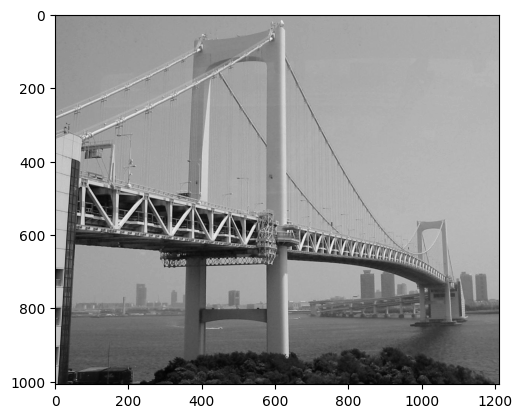

In [8]:
#
# Lecture de l'image 
#
#
#imgc = Image.open("Sydney_Opera_House.jpg")
imgc = Image.open("Tokyo_Rainbow_Bridge.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M        = (1./255)*np.array(img_gray)
M_Tokyo  = M[:]
#
# Affichage de la taille de l'image et de l'image en gris si besoin
#
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.3004424571990967
Estimated upper bound of the epsilon-rank:  160  for relative threshold:  0.05
Frobenius norm ratio:  0.046532218635701665  reached in  10 iterations
[[ 0.          0.0171248   0.01697246 ... -0.09299859 -0.09036452
  -0.09171928]
 [ 1.          0.97743366  0.89605097 ...  0.17552036  0.17256071
   0.16315113]
 [ 0.          0.01103142 -0.03961251 ...  0.08833984  0.0860516
   0.08511591]
 ...
 [ 0.         -0.00763746 -0.0230971  ...  0.10056167  0.10511918
   0.10658742]
 [ 0.         -0.02014886 -0.00697112 ...  0.06526025  0.06073363
   0.05596662]
 [ 0.         -0.01287271 -0.02577002 ...  0.01266169  0.0121644
   0.00997483]]
Time spent in the CUR algorithm 0.4714963436126709
[[-0.18073036 -0.12977141 -0.12787936 ...  0.03892463  0.03296481
   0.01724671]
 [ 0.18336824  0.13960676  0.08627678 ... -0.01007632 -0.00432745
  -0.01254016]
 [-0.10251011 -0.10487345 -0.07732628 ...  0.14034165  0.165997

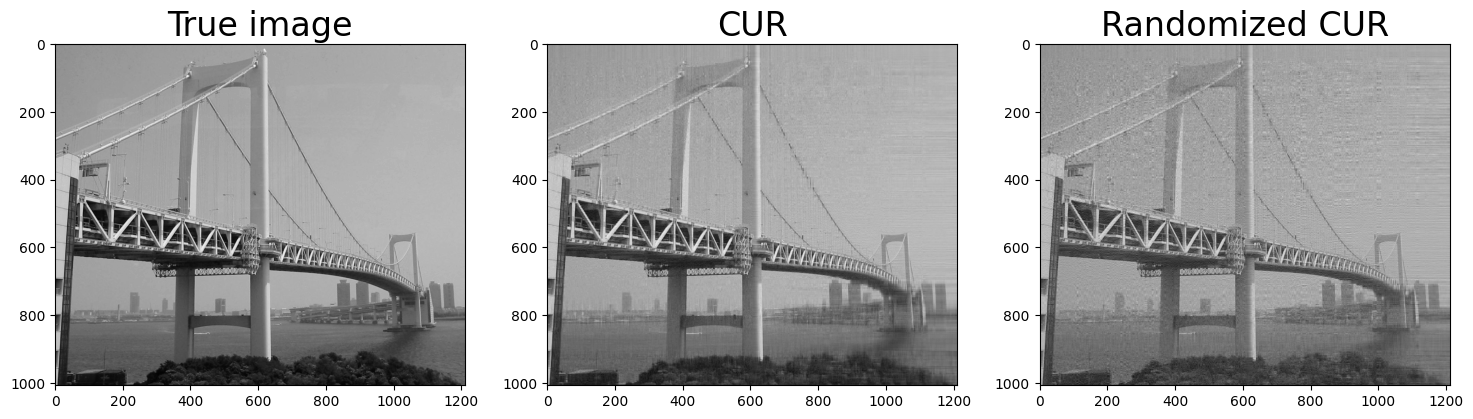

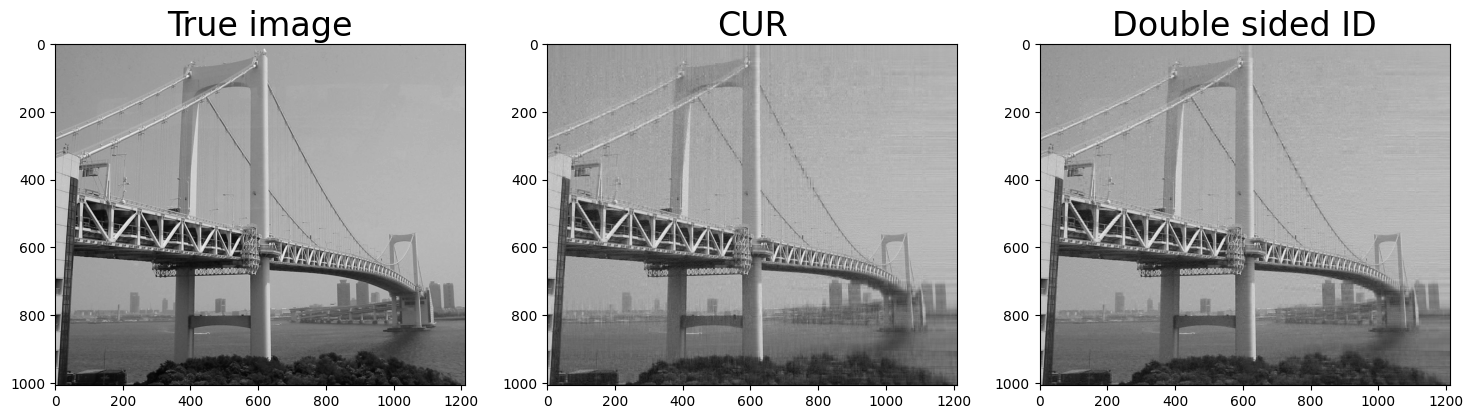

In [9]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
epsilon  = 5.e-2
blocking = 16
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Tokyo = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I, J, C, U, R  = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start        = time.time()
I,J,X,Z        = double_sided_ID(M,erank)
JID_T          = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_T,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Hamburg

(524, 932)


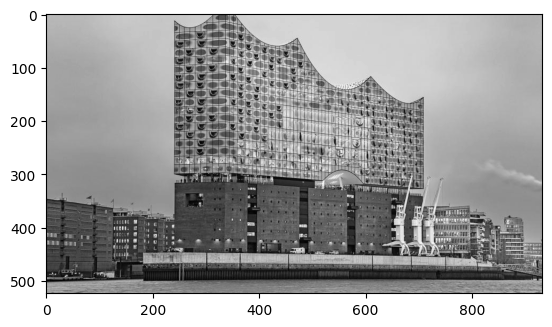

In [10]:
#
# Lecture de l'image [couleur] 
#
#
imgc = Image.open("Hamburg_Elbphilarmonie.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M         = (1./255)*np.array(img_gray)
M_Hamburg = M[:]

print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.17706918716430664
Estimated upper bound of the epsilon-rank:  272  for relative threshold:  0.05
Frobenius norm ratio:  0.04714954792758764  reached in  17 iterations
[[-0.04167513  0.03280797  0.09717357 ... -0.0849949  -0.0669419
  -0.05568794]
 [ 0.01241501  0.0404947   0.04201039 ... -0.00412609 -0.06085865
  -0.0675724 ]
 [-0.04820531 -0.03286956  0.08433851 ... -0.00184414 -0.00827391
  -0.03210683]
 ...
 [-0.00415635  0.00632968  0.06318419 ... -0.0375557   0.00537407
   0.03485697]
 [-0.0307698  -0.03384259  0.02916015 ... -0.02860541 -0.01281347
  -0.02552974]
 [ 0.00630456 -0.00898823  0.00762922 ... -0.05180149 -0.06288055
  -0.09902705]]
Time spent in the CUR algorithm 0.15336251258850098
[[ 0.07872512  0.2256716   0.61508981 ... -0.05481422 -0.17206638
  -0.1866863 ]
 [-0.01062991 -0.07559737  0.06749586 ... -0.02934465  0.14766616
   0.27638864]
 [ 0.09240338  0.09059744 -0.0293128  ... -0.09144865 -0.0912

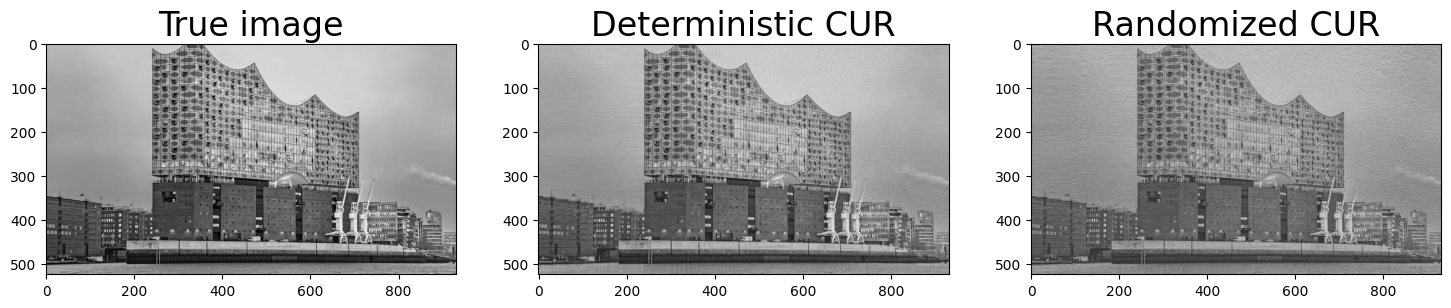

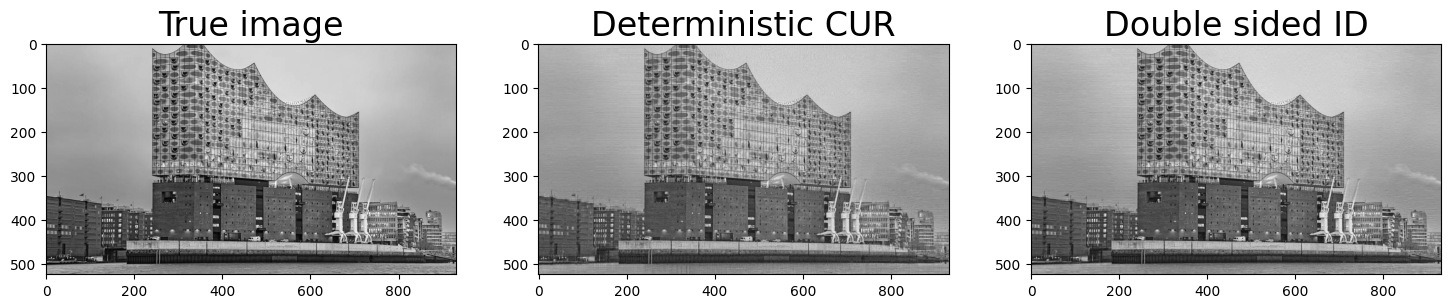

In [11]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Hamburg = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#print(np.shape(R))
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I,J,C, U, R    = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
print(np.shape(R))
#
# Double sided ID
#
t_start  = time.time()
I,J,X,Z  = double_sided_ID(M,erank)
JID_H    = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
print(np.shape(Z))
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('Deterministic CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('Deterministic CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_H,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

**Question:**
* B.1 Prenez trois valeurs pour $\epsilon$ (par exemple $\epsilon=0.5$, $\epsilon=0.1$ et $\epsilon=0.05$) et analysez la qualité de l'approximation pour les images considérées. Qu'observez-vous ? 

**Réponse**:
Plus l'on choisit epsilon faible, plus on améliore la qualité de l'approximation. Cela parait très cohérent puisque epsilon est un terme de précision. Ainsi, plus on demande une précision importante, plus on l'obtient.

***********************************************************************************************************

***********************************************************************************************************

**Question:**
* B.2 Observez-vous des différences de qualité de reconstruction entre les algorithmes pour une précision identique ?

**Réponse**:
En testant avec plusieurs valeurs de epsilon, on remarque que l'on de légères différences de précision selon les 3 méthodes. Les résultats de la méthode "double sided id" semblent être ceux les plus conformes à l'image réelle. Ensuite, la méthode la plus proche est la "deterministic CUR" puis, la méthode "randomized CUR". On remarque notamment pour des précisions assez grossières (0.5 par exemple) que la méthode "randomized CUR" est très hachurée par rapport aux deux autres méthodes.


## Partie C.

En vous basant notamment sur les notes de cours, le chapitre 11 de <a href="https://arxiv.org/pdf/1607.01649.pdf">Martinsson (2019)</a>, la section 13 de <a href="https://arxiv.org/pdf/2002.01387.pdf">Martinsson et Tropp (2020)</a>,  répondre aux deux questions suivantes:

* C.1 Donner les avantages et inconvénients éventuels de la décomposition déterministe CUR-ID. 
En terme de rapidité d'exécution, les 3 algorithmes s'exécutent dans les mêmes temps en ordre de grandeur.

**Réponse**:

Avantages :
- La décomposition CUR-ID ne nécessite pas de calculer la décomposition SVD complète de la matrice d'origine.
- La sélection des colonnes et rangées les plus importantes de la matrice permet de conserver les informations les plus significatives de la matrice d'origine, ce qui peut conduire à des approximations de rang faible plus précises.

Inconvénients :
- La sélection des colonnes et rangées les plus importantes de la matrice est effectuée de manière déterministe. Ceci peut conduire à des approximations de rang faible moins efficaces pour des matrices avec une structure plus complexe.
- La méthode peut être sensible à la variation des valeurs dans la matrice d'origine. Si les valeurs sont très inégales, la méthode peut ne pas fonctionner correctement.

***********************************************************************************************************

***********************************************************************************************************

* C.2 Expliquer comment paralléliser l'algorithme aléatoire CUR-ID. 

On peut paralléliser les produits "matrice-matrice" avec une architecture de type GPU.

**Réponse**:

## Partie D.

Appliquer l'algorithme de factorisation non-négative de <a href="https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf">Lee et Cheung</a> (Théoreme 1) pour obtenir une approximation d'une image donnée en norme de Frobenius. Une attention sera donnée à l'implantation proposée et au temps de restitution obtenu.  Vous pourrez à cet effet utiliser les fonctions multiply et divide de NumPy.

In [12]:
def nmf(M,erank,epsilon,iteration_max):
    """
    Non-negative matrix factorization for matrix M.
    Input: 
    M:             matrix to be analysed [array type] (of shape (m,n))
    erank:         estimated rank (upper bound of epsilon-rank(M))
    epsilon:       relative threshold related to the accuracy of the projection (in the Frobenius norm) (0<= epsilon <= 1)
    iteration_max: maximal number of iterations [int]
    
    Output:
    X,Y: matrices with positive entries such that $ \|M - X Y \|_F \le \epsilon \|M \|_F$
    iteration: effective number of iterations
    """
    m     = np.shape(M)[0] # nombre de lignes de la matrice M
    n     = np.shape(M)[1] # nombre de colonnes de la matrice M
    
    # Specify two possible first iterates for X and Y
    X = np.random.rand(m,erank) 
    Y = np.random.rand(erank,n)
    # X = np.ones((m,erank))
    # Y = np.ones((erank,n))

    # Set variables
    norm_A_Fro    = norm(M,'fro')
    iteration     = 0
    
    # Algorithm 
    while norm(M-X@Y,'fro') > epsilon*norm_A_Fro and iteration < iteration_max:
        #
        # TO DO
        #
        Y = np.multiply(Y, np.divide((X.T)@M, (X.T)@X@Y))
        X = np.multiply(X, np.divide(M@(Y.T), X@Y@(Y.T)))
        iteration += 1
        #
        # END TO DO
        #
        if iteration%25 == 0:
            print(iteration,norm(M-X@Y,'fro')/norm_A_Fro)

    return X,Y,iteration

25 0.22662034499785572
50 0.1774118252324129
75 0.14676255234858643
100 0.12660310279627354
125 0.11317896296202631
150 0.10377432449490781
175 0.09687067618604829
200 0.09158813331019937
225 0.08740591625663303
250 0.08399984698662513
275 0.08116128648294203
300 0.07875169167797248
325 0.07667615578667175
350 0.07486688473488591
375 0.07327459919507034
400 0.07186191671201786
425 0.07059991970524082
450 0.06946610831114576
475 0.06844193180774123
500 0.06751202969300689
525 0.06666386123372041
550 0.06588709382482097
575 0.0651729147650237
600 0.06451381934357953
625 0.06390346441139196
650 0.06333650978471504
675 0.0628082829604589
700 0.06231475091698987
725 0.06185260717423778
750 0.06141894610846017
775 0.06101105886748308
800 0.060626566651252885
825 0.06026340004817762
850 0.05991974567255903
875 0.059594044699265394
900 0.059284853942095955
925 0.05899082407815628
950 0.05871075430708346
975 0.058443553940515355
1000 0.05818821875530091
1025 0.05794389615193939
1050 0.057709873

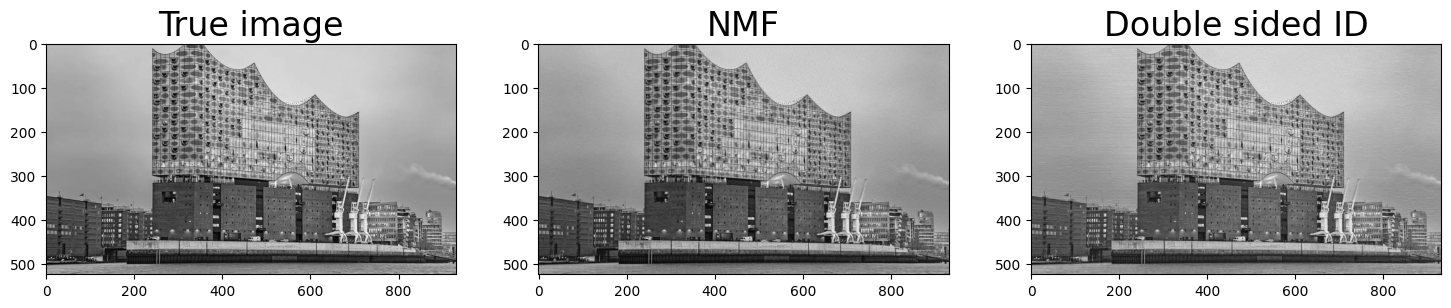

In [13]:
#
# Specify one of the target images here
#
erank = erank_Hamburg
M     = M_Hamburg[:]
JID   = JID_H[:]
#
# NMF 
#
iteration_max = 3500
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

25 0.20364187356038468
50 0.1292956729222375
75 0.10247895096519474
100 0.0881970260088715
125 0.07854920102718664
150 0.0715906031631513
175 0.06637765664806913
200 0.062343771987167375
225 0.0591487441988665
250 0.05656758851516742
275 0.05444632425900763
300 0.0526771160549675
325 0.051181074302526906
Time spent in the non-negative matrix factorization (NMF) 2.381854295730591
Norm ratio:  0.04999512866423573  reached in  348 iterations


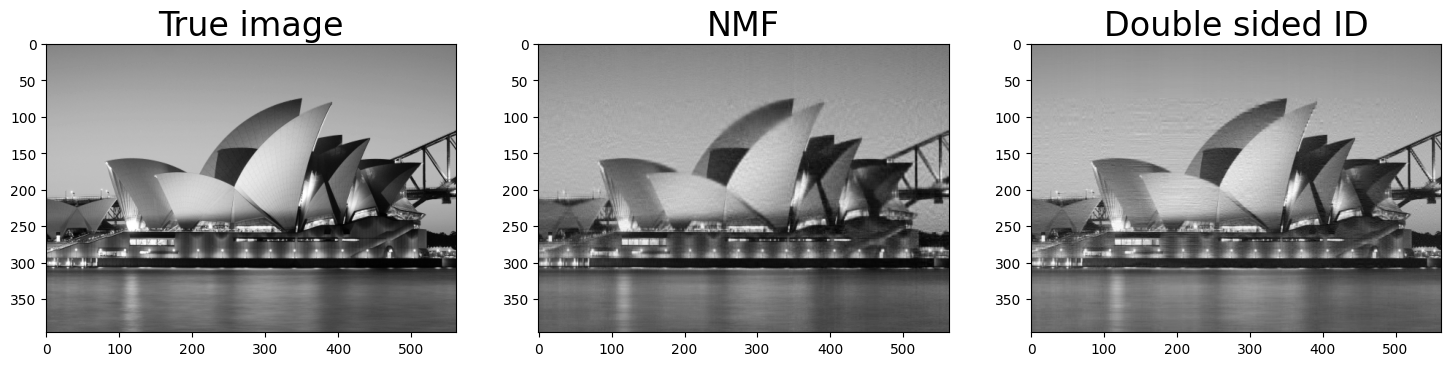

In [14]:
#
# Specify one of the target images here
#
erank = erank_Sydney
M     = M_Sydney[:]
JID   = JID_S[:]
#
# NMF 
#
iteration_max = 2000
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

25 0.20223905816270446
50 0.15582653498252041
75 0.12840790215094808
100 0.107606578305615
125 0.09425269021584103
150 0.0855518031441291
175 0.0794234567485823
200 0.07479788248438672
225 0.07112596146600526
250 0.06812639247118052
275 0.0656189967193917
300 0.06347887202991695
325 0.061622167718569404
350 0.059991611895534105
375 0.05854780685507718
400 0.057261260404316415
425 0.056107671730062036
450 0.055067120799241955
475 0.054123571049300344
500 0.05326407289606097
525 0.052478024240576085
550 0.05175658676807011
575 0.05109226203795012
600 0.0504786272431601
Time spent in the non-negative matrix factorization (NMF) 23.265326261520386
Norm ratio:  0.04999829840298924  reached in  621 iterations


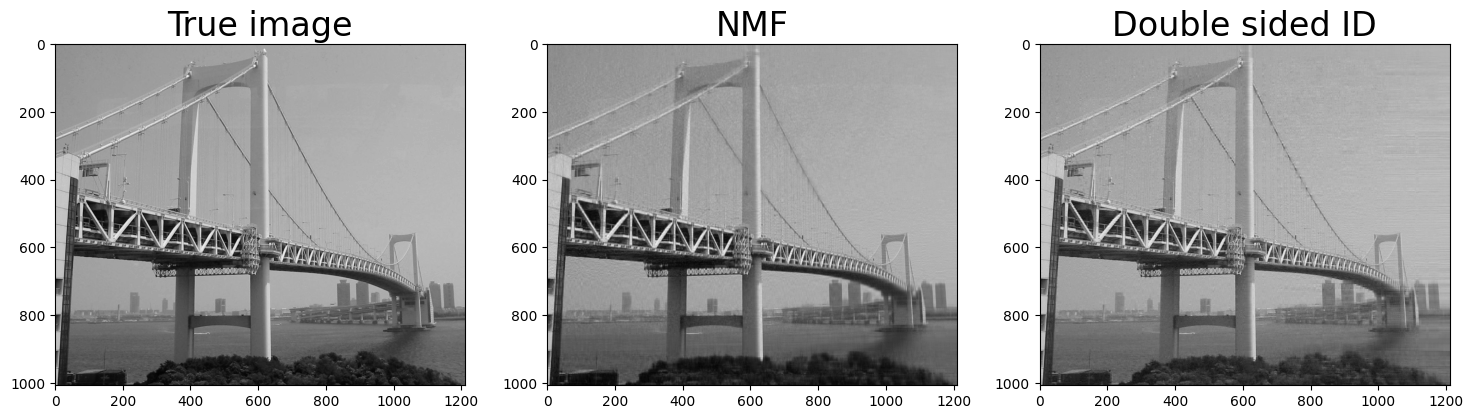

In [15]:
#
# Specify one of the target images here
#
erank = erank_Tokyo
M     = M_Tokyo[:]
JID   = JID_T[:]
#
# NMF 
#
iteration_max = 2000
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Questions:

* D.1 Pour $\epsilon=0.05$, indiquer pour chacune des images le temps de restitution et le nombre d'itérations. Commenter la vitesse de convergence de la méthode et la qualité de l'image reconstruite.

**Réponse**:

Hamburg

    - temps de restitution : 69 sec

    - nombre d'itérations : 3127 itérations

Sydney

    - temps de restitution : 3 sec

    - nombre d'itérations : 348 itérations
    
Tokyo

    - temps de restitution : 24 sec
    
    - nombre d'itérations : 621 itérations

Le résultat de Hamburg est le meilleur, suivi de Sydney et de Tokyo. Néanmoins, on remarque que la convergence est très longue dans le cas d'Hamburg et longue dans le cas de Tokyo pour $\epsilon=0.05$. 

On pourrait penser que la vitesse de convergence serait directement liée au nombre de pixels dans l'image mais il n'y a priori pas de lien évident.
On remarque en tout cas que, plus il y a d'itérations et plus la vitesse de convergence est longue, plus le rendu de la photo à la sortie de la méthode NMF (image reconstruite) semble de bonne qualité.

***********************************************************************************************************

***********************************************************************************************************

* D.2 A chaque fois, nous avons considéré une image exacte dans chacun des algorithmes pour en déduire une approximation de rang faible. Comment obtenir une approximation de rang faible si l'on dispose uniquement d'une image de qualité médiocre comme image initiale ? Proposez un algorithme. 

**Réponse**:

Pour obtenir une approximation de rang faible à partir d'une image de qualité médiocre, on peut utiliser des techniques de débruitage ou des réseaux de neurones profonds pour améliorer la qualité de l'image avant d'appliquer des algorithmes d'approximation de rang faible.

Un exemple d'algorithme de débruitage est la décomposition en valeurs singulières (SVD). Cette méthode consiste à décomposer la matrice de l'image en une combinaison de matrices de rang plus faible, qui peuvent être utilisées pour réduire le bruit dans l'image.

***********************************************************************************************************

***********************************************************************************************************

* Bonus Quel(s) algorithme(s) utiliseriez-vous pour approcher (au sens de l'approximation de rang faible) non pas une image mais une séquence d'images (donnée par exemple au sein d'une video) ? 

**Réponse**:

Pour approximer une séquence d'images, on peut utiliser une extension de l'analyse en composantes principales (ACP) appelée "Analyse en Composantes Temporelles" (ACT). Cette méthode permet de capturer la structure temporelle de la séquence d'images en décomposant chaque image en une combinaison de composantes temporelles. Il suffirait ensuite de garder la projection sur les composantes principales pour avoir un rang plus faible.

Une autre méthode populaire pour approximer des séquences d'images est l'utilisation de l'analyse tensorielle, qui permet de modéliser des données multidimensionnelles telles que les séquences d'images. 

Enfin, une autre méthode pour approximer une séquence d'images est d'utiliser les réseaux de neurones récurrents, tels que les réseaux LSTM (Long-Short Term Memory) ou GRU (Gated Recurrent Unit). Ces réseaux sont capables de prendre en compte la structure temporelle des séquences d'images pour extraire des caractéristiques significatives.

En fonction des spécificités du problème, il faut choisir la méthode la plus adaptée.

### Références  (articles et exposés)

## Articles

* D. Lee and S. Cheung. <a href="https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf">Algorithms for Non-negative Matrix Factorization </a>. Advances in Neural Information Processing Systems 13 (NIPS 2000). 


* P.-G.  Martinsson.  <a href="https://arxiv.org/pdf/1607.01649.pdf">Randomized  methods  for  matrix  computations</a>.  In  M.W.  Mahoney,  J.C.  Duchi,  and  A.C.  Gilbert, editors, The Mathematics of Data, volume 25, chapter 4, pages 187 – 231. American Mathematical Society, IAS/ParkCity Mathematics Series, 2018.


* P.-G.  Martinsson and J. Tropp.  <a href="https://arxiv.org/pdf/2002.01387.pdf">Randomized Numerical Linear Algebra: Foundations & Algorithms</a>. Acta Numerica, 29, pp 403-572, 2020.


* S. Voronin, P.-G.  Martinsson and  <a href="https://users.oden.utexas.edu/~pgm/Pubs/2017_voronin_CUR.pdf">Efficient Algorithms for CUR and Interpolative Matrix Decompositions</a>. Advances in Computational Mathematics, Volume 43, Issue 3, pp 495–516, 2017.

## Exposés

* P.-G.  Martinsson. <a href="https://simons.berkeley.edu/talks/randomized-algorithms-computing-full-matrix-factorizations">Randomized Algorithms for Computing Full Matrix Factorizations</a>, talk given at  
Randomized Numerical Linear Algebra and Applications, September 2018, Simons Institute, Berkeley, 2018.


* P.-G.  Martinsson. <a href="https://www.youtube.com/watch?v=l262Qij6flM">Randomized algorithms for pivoting and for computing interpolatory and CUR factorizations</a>, talk given at E-Numerical Linear Algebra seminars, March 2021.
